In [47]:
import pandas as pd
import numpy as np
import tqdm
import os
import warnings
warnings.filterwarnings('ignore')
np.random.seed()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import math
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Conv1D
from matplotlib import pyplot as plt
import keras
# !pip install -q -U keras-tuner
import keras_tuner as kt
import tensorflow as tf

# Data cleaning and normalization

In [48]:
training_session_folder = 'C:/Users/chiny/cjwen/ITI110/hourly_training'
df = pd.read_csv("2.2 merged_aggregated_hourly_without_block_id.csv")


In [49]:
df.isnull().sum()      

date                     0
month                    0
hour                     0
count_LCLid              0
count_block_id           0
sum_energy_by_hour       0
tstp                     0
avg_energy_per_lclid     0
holiday                  0
visibility               2
windBearing              2
temperature              2
time                     2
dewPoint                 2
pressure                13
apparentTemperature      2
windSpeed                2
precipType               2
icon                     2
humidity                 2
summary                  2
dtype: int64

In [50]:
df = df.drop(['precipType', 'icon', 'summary'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df['time'] = pd.to_datetime(df['time'])
df['tstp'] = pd.to_datetime(df['tstp'])
# Filter rows where 'tstp' and 'time' differ
filtered_df = df[df['tstp'] != df['time']]

# Display the differences
filtered_df[['date', 'tstp', 'time']]

,date,tstp,time
15758,2013-09-09,2013-09-09 23:00:00,NaT
15759,2013-09-10,2013-09-10 00:00:00,NaT


In [51]:
df = df.drop([15758, 15759])

In [52]:
df['pressure'] = df['pressure'].fillna(df['pressure'].mean())


# Create X new columns using past X timestamp data

In [53]:
dataframe = df.loc[:,"avg_energy_per_lclid"]
dataset = dataframe.values
dataset = dataset.astype("float32")

In [54]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [55]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)



,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385
8,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538
9,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154


In [56]:
scaler_label = MinMaxScaler(feature_range=(0, 1))

In [57]:
# Merge the reframed columns with weather and time features

In [58]:
reframed["month"] = df.month.values[7:]
reframed["hour"] = df.hour.values[7:]
reframed["temperature"] = df.temperature.values[7:]
reframed["humidity"] = df.humidity.values[7:]
reframed["windSpeed"] = df.windSpeed.values[7:]
reframed["holiday"] = df.holiday.values[7:]

In [59]:
reframed_tstp = pd.DataFrame()
reframed_tstp["tstp"] = df.tstp.values[7:]

In [60]:
reframed_tstp

,tstp
0,2011-11-23 16:00:00
1,2011-11-23 17:00:00
2,2011-11-23 18:00:00
3,2011-11-23 19:00:00
4,2011-11-23 20:00:00
...,...
19850,2014-02-27 20:00:00
19851,2014-02-27 21:00:00
19852,2014-02-27 22:00:00
19853,2014-02-27 23:00:00


In [61]:
reframed

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),month,hour,temperature,humidity,windSpeed,holiday
7,0.565000,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,11,16,9.84,0.86,2.95,0.0
8,0.251333,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,11,17,9.14,0.92,2.58,0.0
9,0.303286,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,11,18,9.12,0.90,2.91,0.0
10,0.658900,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,11,19,9.07,0.93,3.06,0.0
11,0.481769,0.475692,0.377077,0.374385,0.474538,0.523154,0.773923,0.861846,11,20,8.69,0.93,2.96,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19857,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,2,20,5.94,0.76,3.25,0.0
19858,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,2,21,5.03,0.79,3.06,0.0
19859,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,2,22,4.10,0.84,3.02,0.0
19860,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473,2,23,3.93,0.85,2.75,0.0


In [62]:
reframed = reframed.reindex(["month","hour","temperature","humidity","windSpeed","holiday",'var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'],axis=1)

In [63]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19855 entries, 7 to 19861
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        19855 non-null  int64  
 1   hour         19855 non-null  int64  
 2   temperature  19855 non-null  float64
 3   humidity     19855 non-null  float64
 4   windSpeed    19855 non-null  float64
 5   holiday      19855 non-null  float64
 6   var1(t-7)    19855 non-null  float32
 7   var1(t-6)    19855 non-null  float32
 8   var1(t-5)    19855 non-null  float32
 9   var1(t-4)    19855 non-null  float32
 10  var1(t-3)    19855 non-null  float32
 11  var1(t-2)    19855 non-null  float32
 12  var1(t-1)    19855 non-null  float32
 13  var1(t)      19855 non-null  float32
dtypes: float32(8), float64(4), int64(2)
memory usage: 1.7 MB


In [64]:
scaler = MinMaxScaler(feature_range=(0, 1))

reframed[["month","hour","temperature","humidity","windSpeed","holiday"]] = scaler.fit_transform(reframed[["month","hour","temperature","humidity","windSpeed","holiday"]])

In [65]:
train_rows = int(0.8*len(reframed))
train = reframed[:train_rows]
test = reframed[train_rows:]

print("dataset no. of rows: ", len(reframed))
print("train dataset no. of rows: ", len(train))
print("test dataset no. of rows: ", len(test))

dataset no. of rows:  19855
train dataset no. of rows:  15884
test dataset no. of rows:  3971


In [66]:
train_tstp = reframed_tstp[:train_rows]
test_tstp = reframed_tstp[train_rows:]

print("dataset no. of rows: ", len(reframed_tstp))
print("train_tstp dataset no. of rows: ", len(train_tstp))
print("test_tstp dataset no. of rows: ", len(test_tstp))

dataset no. of rows:  19855
train_tstp dataset no. of rows:  15884
test_tstp dataset no. of rows:  3971


In [67]:
test.tail()

,month,hour,temperature,humidity,windSpeed,holiday,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
19857,0.090909,0.869565,0.304416,0.688312,0.217480,0.0,0.398630,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360
19858,0.090909,0.913043,0.280494,0.727273,0.204607,0.0,0.381376,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011
19859,0.090909,0.956522,0.256046,0.792208,0.201897,0.0,0.394907,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121
19860,0.090909,1.000000,0.251577,0.805195,0.183604,0.0,0.428821,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473
19861,0.090909,0.000000,0.248423,0.805195,0.168699,0.0,0.507056,0.658782,0.722878,0.694360,0.657011,0.587121,0.469473,0.209844


In [68]:
features = ["month", "hour", "temperature","humidity","windSpeed","holiday", "var1(t-7)","var1(t-6)","var1(t-5)","var1(t-4)","var1(t-3)","var1(t-2)","var1(t-1)"]
label = ["var1(t)"]

In [69]:
# train_X = np.array(train[features])
# train_y = np.array(train[label])
# test_X = np.array(test[features])
# test_y = np.array(test[label])

In [70]:
x_train = np.array(train[features])
y_train = np.array(train[label])
x_test = np.array(test[features])
y_test = np.array(test[label])

In [72]:
train_X.shape

(15884, 13)

In [73]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape) 

(15884, 1, 13) (15884, 1) (3971, 1, 13) (3971, 1)


In [74]:
def performance_visualization(model, train_input, train_actual, test_input, test_actual, start_row=0, end_row=100):
    train_result = pd.DataFrame()
    train_pred = model.predict(train_input)
    train_mae = mae(train_actual, train_pred)
    train_mape = mape(train_actual,train_pred)
    train_rmse = math.sqrt(mean_squared_error(train_actual,train_pred))
    train_result["tstp"] = train_tstp["tstp"]
    train_result["tstp"] = pd.to_datetime(train_result["tstp"])
    train_result["train_pred"]= train_pred
    train_result["train_actual"]= train_actual
    print(f"Train MAE: {train_mae}")
    print(f"Train MAPE: {train_mape}")
    print(f"Train RMSE: {train_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "train_actual", label='actual', data = train_result[start_row:end_row])
    plt.plot("tstp", "train_pred", label='prediction', data = train_result[start_row:end_row])

    # plt.plot(train_pred[start_row:end_row], label='prediction', x = "tstp")
    plt.title("Train Actual vs prediction")
    plt.legend()
    plt.show()
              
              
    test_result = pd.DataFrame()
    test_pred = model.predict(test_input)
    test_mae = mae(test_actual, test_pred)
    test_mape = mape(test_actual,test_pred)
    test_rmse = math.sqrt(mean_squared_error(test_actual,test_pred))
    test_result["tstp"] = test_tstp["tstp"]
    test_result["tstp"] = pd.to_datetime(test_result["tstp"])
    test_result["test_pred"]= test_pred
    test_result["test_actual"]= test_actual
    print(f"Test MAE: {test_mae}")
    print(f"Test MAPE: {test_mape}")
    print(f"Test RMSE: {test_rmse}")
    plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
    plt.plot("tstp", "test_actual", label='actual', data = test_result[start_row:end_row])
    plt.plot("tstp", "test_pred", label='prediction', data = test_result[start_row:end_row])
    plt.title("Test Actual vs prediction")
    plt.legend()
    plt.show()          
    
    return train_result, test_result

# Run 10 - 2 layers LSTM 96 neurons

In [28]:
model1 = Sequential()
    
model1.add(LSTM(units = 96, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model1.add(LSTM(units = 96))
model1.add(Dense(1))
    
model1.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[keras.metrics.MeanAbsoluteError()])

In [29]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_10/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.3f}-val_MAE-{val_mean_absolute_error:4.3f}-loss-{val_loss:4.3f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]

Epoch 1/500

497/497 [==============================] - 5s 4ms/step - loss: 0.0600 - mean_absolute_error: 0.0600 - val_loss: 0.0340 - val_mean_absolute_error: 0.0340
Epoch 2/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0308 - mean_absolute_error: 0.0308 - val_loss: 0.0255 - val_mean_absolute_error: 0.0255
Epoch 3/500
497/497 [==============================] - 2s 3ms/step - loss: 0.0274 - mean_absolute_error: 0.0274 - val_loss: 0.0265 - val_mean_absolute_error: 0.0265
Epoch 4/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0249 - mean_absolute_error: 0.0249 - val_loss: 0.0271 - val_mean_absolute_error: 0.0271
Epoch 5/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0241 - mean_absolute_error: 0.0241 - val_loss: 0.0218 - val_mean_absolute_error: 0.0218
Epoch 6/500
497/497 [==============================] - 1s 3ms/step - loss: 0.0232 - mean_absolute_error: 0.0232 - val_loss: 0.0249 - val_mean_absolute_error: 0.0249
Epoch 7/5

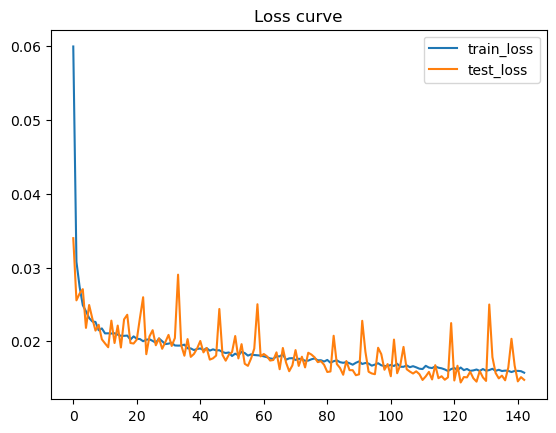

In [30]:
history = model1.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

497/497 [==============================] - 1s 1ms/step
Train MAE: 0.015575499273836613
Train MAPE: 0.03585226833820343
Train RMSE: 0.022399330651578293


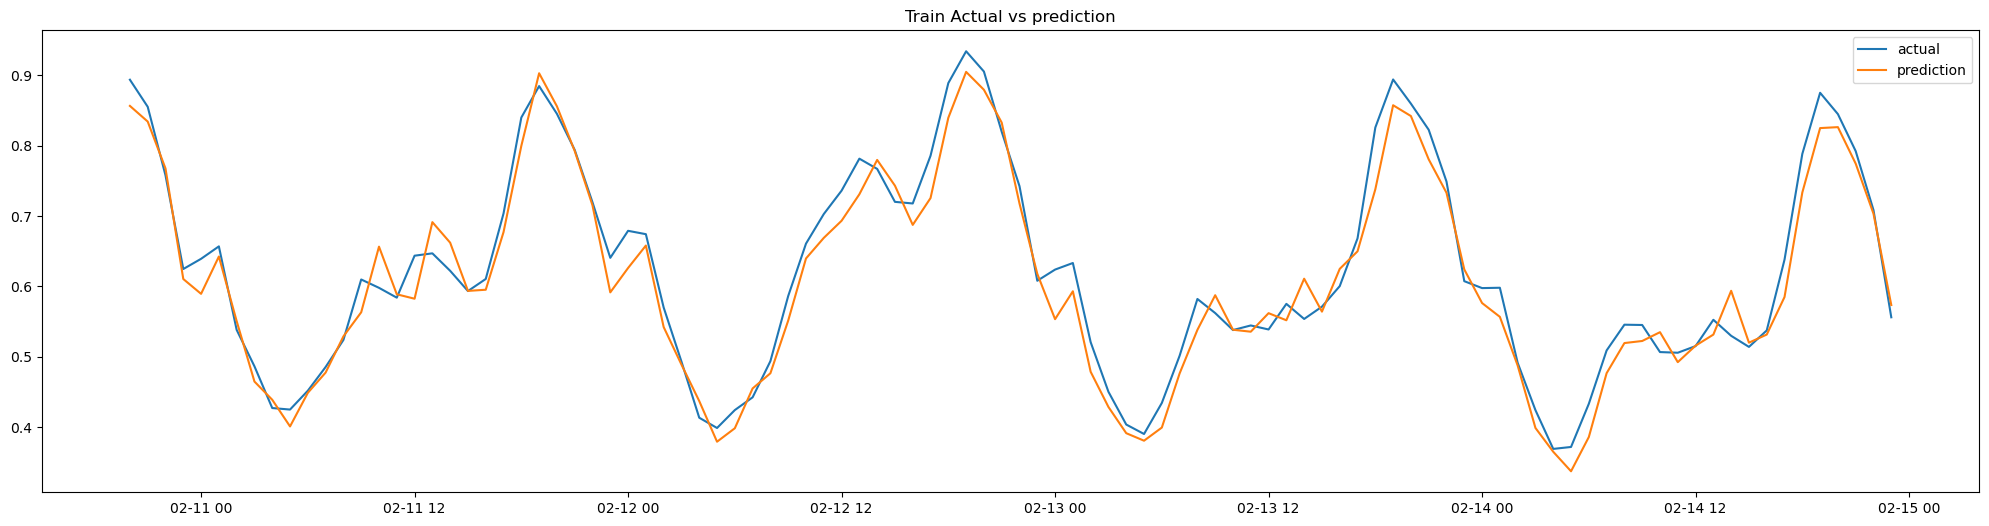

125/125 [==============================] - 0s 1ms/step
Test MAE: 0.014767156913876534
Test MAPE: 0.03447109833359718
Test RMSE: 0.01974722319093339


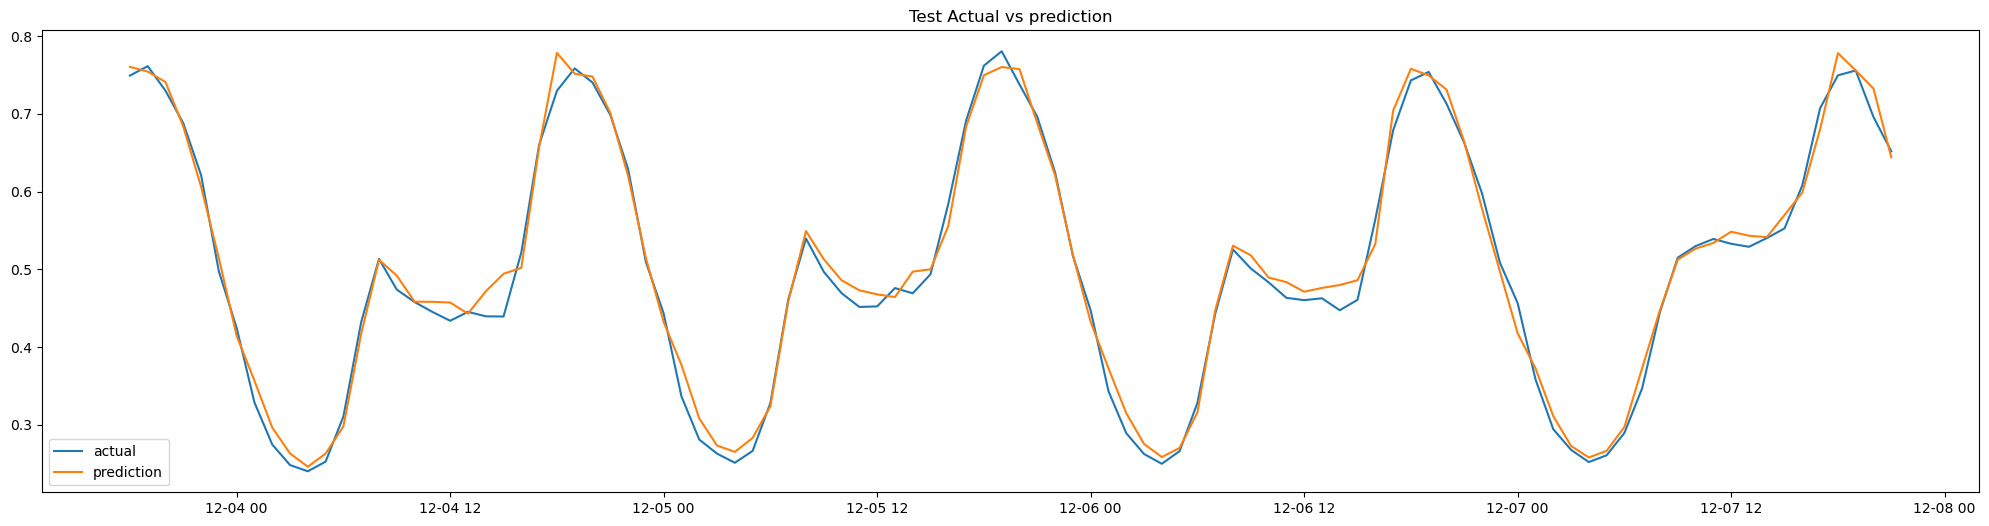

In [43]:
train_result, test_result = performance_visualization(model1, x_train, y_train, x_test, y_test, 1900, 2000)

In [78]:
test_result["delta"] = abs(test_result["test_pred"] - test_result["test_actual"])
test_result["percentage_delta"] = (abs(test_result["test_pred"] - test_result["test_actual"]))/abs(test_result["test_actual"])
test_result["hour"] = test_result["tstp"].dt.hour.astype('str')
test_result["month"] = test_result["tstp"].dt.month.astype('str')
test_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3971 entries, 15884 to 19854
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   tstp              3971 non-null   datetime64[ns]
 1   test_pred         3971 non-null   float32       
 2   test_actual       3971 non-null   float32       
 3   delta             3971 non-null   float32       
 4   hour              3971 non-null   object        
 5   month             3971 non-null   object        
 6   percentage_delta  3971 non-null   float32       
dtypes: datetime64[ns](1), float32(4), object(2)
memory usage: 155.2+ KB


In [79]:
import seaborn as sns

In [67]:
# plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
# ax = sns.catplot(data=test_result, y = "delta", hue = "hour", alpha=.3, marker="D")

In [68]:
# plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
# sns.displot(test_result, x="delta", hue = "hour")

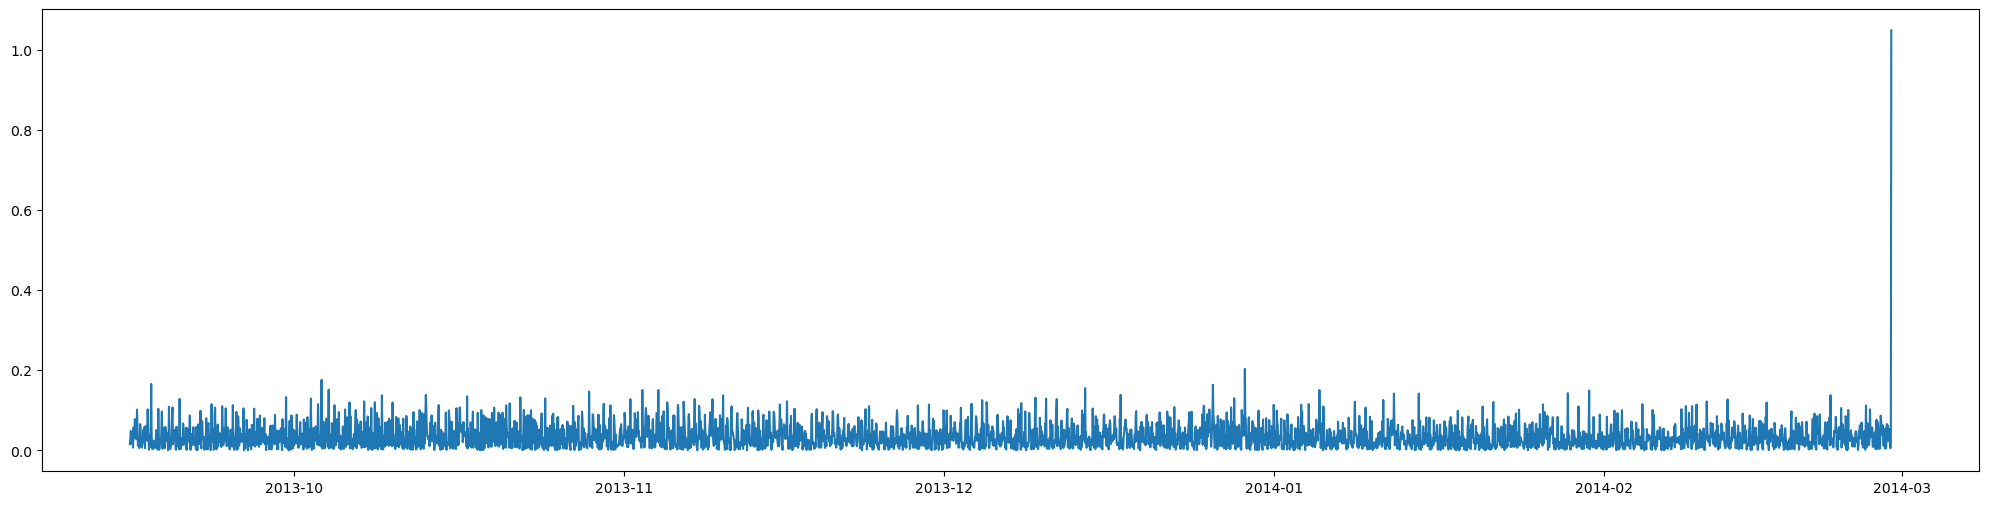

In [80]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot("tstp", "percentage_delta", data=test_result)

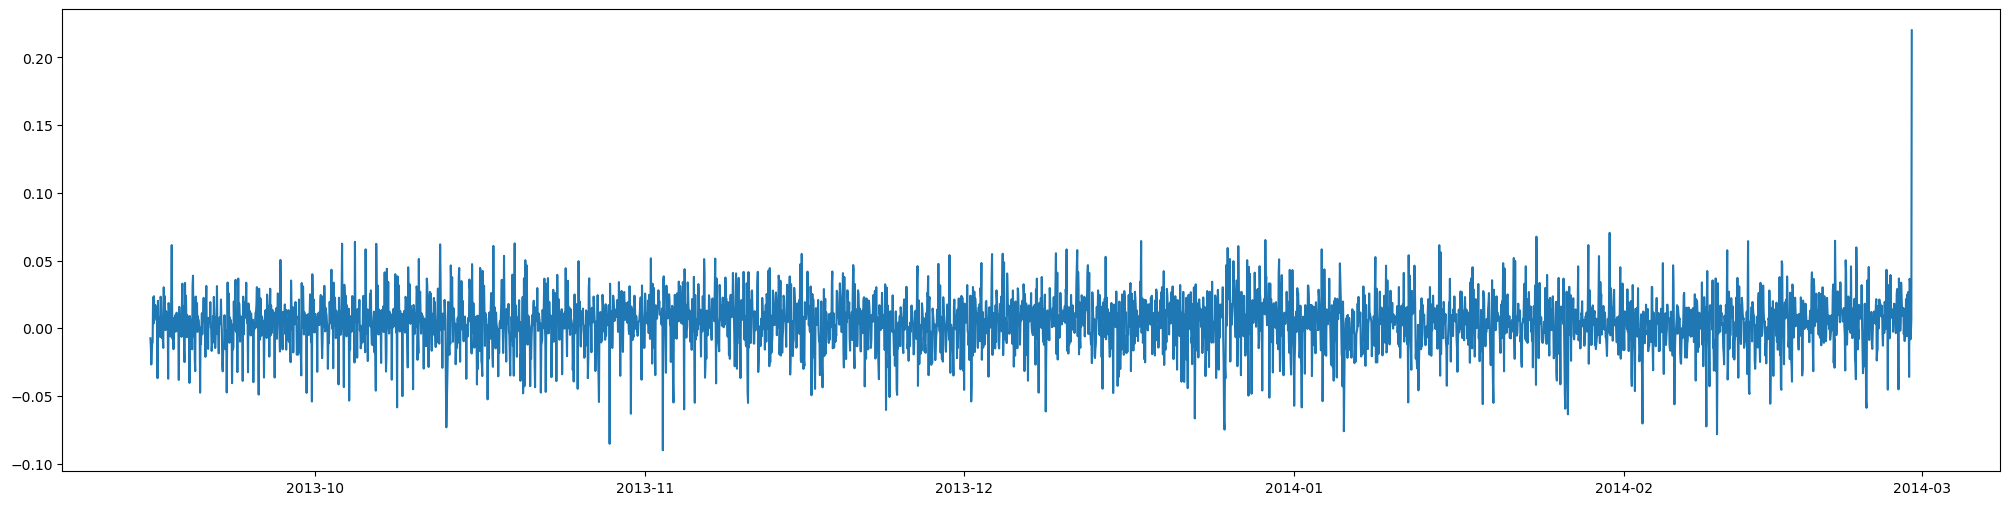

In [49]:
plt.figure(figsize=(25, 6))  # Optional: Adjusts the size of the figure
plt.plot("tstp", "delta", data=test_result)

In [81]:
delta_by_hour = pd.DataFrame()
delta_by_hour = test_result["delta"].groupby(test_result["hour"]).describe()
delta_by_hour.sort_values(by="50%")

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
4,165.0,0.005167,0.003346,0.000050,0.002587,0.005027,0.007480,0.016255
21,166.0,0.007148,0.006299,0.000035,0.002640,0.005486,0.010945,0.046063
3,165.0,0.007641,0.003587,0.000029,0.005115,0.007307,0.010055,0.017626
12,165.0,0.009584,0.007836,0.000031,0.003513,0.007555,0.012257,0.036151
6,165.0,0.013404,0.013579,0.000322,0.003915,0.007827,0.016942,0.053438
10,165.0,0.010856,0.010233,0.000123,0.003898,0.008624,0.013817,0.068657
23,166.0,0.010019,0.008005,0.000209,0.003720,0.008874,0.014479,0.051110
9,165.0,0.011288,0.009460,0.000052,0.004813,0.009102,0.015177,0.073193
11,165.0,0.011583,0.009984,0.000042,0.004892,0.009872,0.016410,0.074853


In [76]:
stat_styled=stat_by_hour.drop(columns = "count", axis=1).style.background_gradient()
stat_styled

,mean,std,min,25%,50%,75%,max
hour,,,,,,,
0,0.017051,0.020819,0.000183,0.005384,0.011075,0.023939,0.220015
1,0.018484,0.007169,0.002949,0.012992,0.017434,0.024029,0.040443
10,0.010856,0.010233,0.000123,0.003898,0.008624,0.013817,0.068657
11,0.011583,0.009984,0.000042,0.004892,0.009872,0.016410,0.074853
12,0.009584,0.007836,0.000031,0.003513,0.007555,0.012257,0.036151
13,0.013500,0.010124,0.000097,0.004954,0.012002,0.020031,0.044547
14,0.024524,0.013153,0.000646,0.014941,0.024622,0.032444,0.062409
15,0.022813,0.017033,0.000086,0.009044,0.017986,0.033055,0.070452
16,0.018773,0.015852,0.000003,0.005824,0.015686,0.027149,0.076081


In [82]:
percentage_delta_by_hour = pd.DataFrame()
percentage_delta_by_hour = test_result["percentage_delta"].groupby(test_result["hour"]).describe()
percentage_delta_by_hour.sort_values(by="50%")

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
21,166.0,0.011358,0.010041,0.000057,0.004169,0.008936,0.016845,0.076937
12,165.0,0.020344,0.014919,0.000085,0.007821,0.017421,0.027892,0.068357
10,165.0,0.023616,0.019797,0.000268,0.009461,0.018867,0.032212,0.110376
22,166.0,0.025169,0.022086,0.000488,0.008849,0.019608,0.035908,0.112000
9,165.0,0.024545,0.019764,0.000106,0.010765,0.020043,0.033739,0.138167
23,166.0,0.023032,0.017958,0.000586,0.008009,0.021109,0.034694,0.101915
19,166.0,0.029758,0.026195,0.000112,0.009951,0.021426,0.042302,0.112424
4,165.0,0.022230,0.014100,0.000223,0.011369,0.021432,0.031855,0.064995
11,165.0,0.025283,0.018781,0.000093,0.010617,0.022444,0.036146,0.111211


In [84]:
percentage_delta_styled=percentage_delta_by_hour.drop(columns = "count", axis=1).style.background_gradient()
percentage_delta_styled

,mean,std,min,25%,50%,75%,max
hour,,,,,,,
0,0.045658,0.083975,0.000512,0.015512,0.031751,0.059589,1.048466
1,0.060806,0.021801,0.008567,0.046643,0.057584,0.077329,0.120204
10,0.023616,0.019797,0.000268,0.009461,0.018867,0.032212,0.110376
11,0.025283,0.018781,0.000093,0.010617,0.022444,0.036146,0.111211
12,0.020344,0.014919,0.000085,0.007821,0.017421,0.027892,0.068357
13,0.030489,0.023887,0.000248,0.010750,0.025640,0.043783,0.105940
14,0.056984,0.033553,0.001439,0.031043,0.055384,0.074742,0.175871
15,0.050472,0.038293,0.000224,0.020706,0.038739,0.075612,0.149148
16,0.034614,0.026953,0.000006,0.010693,0.031844,0.051011,0.121905


# Run 15 - 2 layers LSTM with keras tuner

In [75]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_2))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [76]:
tuner15=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 50, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [36]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_15/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [37]:
tuner15.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters


Trial 90 Complete [00h 01m 55s]
val_mean_absolute_error: 0.019701773300766945

Best val_mean_absolute_error So Far: 0.013977906666696072
Total elapsed time: 02h 57m 20s


In [40]:
best_hps=tuner15.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')}, second LSTM layer is {best_hps.get('units_2')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is 480, second LSTM layer is 480 and the optimal learning rate for the optimizer
is 0.01.



In [91]:
model15 = Sequential()

model15.add(LSTM(units = 480, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model15.add(LSTM(units = 480))
model15.add(Dense(1))
model15.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[keras.metrics.MeanAbsoluteError()])

In [92]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_15/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

Epoch 1/500
497/497 [==============================] - 10s 13ms/step - loss: 0.0484 - mean_absolute_error: 0.0484 - val_loss: 0.0353 - val_mean_absolute_error: 0.0353
Epoch 2/500
497/497 [==============================] - 5s 11ms/step - loss: 0.0325 - mean_absolute_error: 0.0325 - val_loss: 0.0402 - val_mean_absolute_error: 0.0402
Epoch 3/500
497/497 [==============================] - 5s 11ms/step - loss: 0.0270 - mean_absolute_error: 0.0270 - val_loss: 0.0247 - val_mean_absolute_error: 0.0247
Epoch 4/500
497/497 [==============================] - 6s 11ms/step - loss: 0.0242 - mean_absolute_error: 0.0242 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 5/500
497/497 [==============================] - 6s 11ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0246 - val_mean_absolute_error: 0.0246
Epoch 6/500
497/497 [==============================] - 6s 11ms/step - loss: 0.0227 - mean_absolute_error: 0.0227 - val_loss: 0.0239 - val_mean_absolute_error: 0.0239
Epo

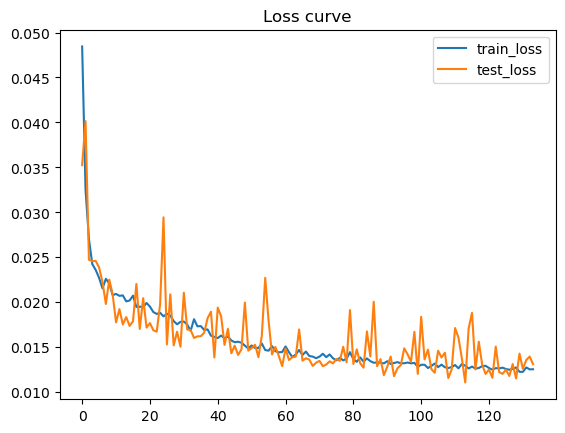

In [93]:
history = model15.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

497/497 [==============================] - 1s 2ms/step
Train MAE: 0.012549157254397869
Train MAPE: 0.029413998126983643
Train RMSE: 0.01815574776785618


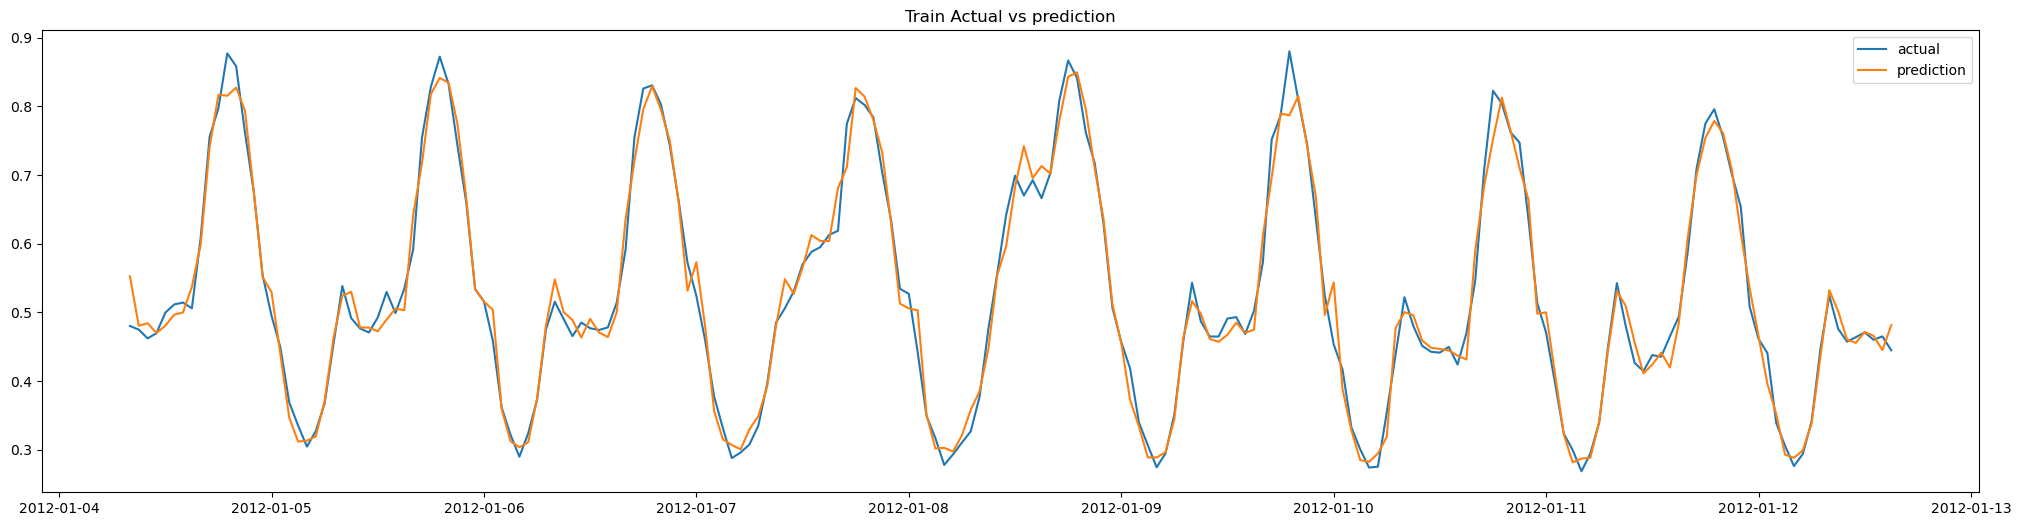

125/125 [==============================] - 0s 2ms/step
Test MAE: 0.013116704300045967
Test MAPE: 0.030863681808114052
Test RMSE: 0.01764186257645189


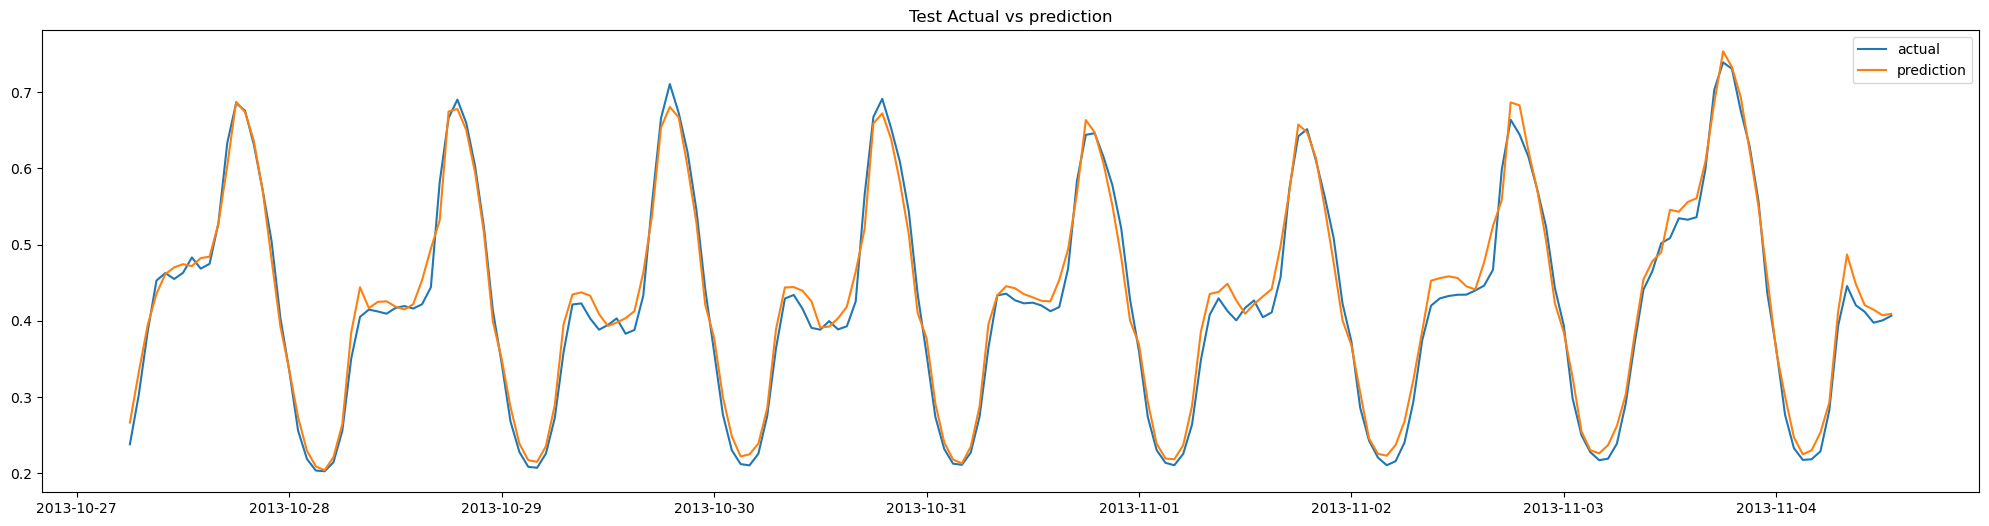

In [102]:
train_result, test_result = performance_visualization(model15,x_train,y_train,x_test,y_test,1000,1200)

# Run 16 3 layers LSTM with keras tuner

In [77]:
def model_builder(hp):
    model = Sequential()
    
    # Tune the number of units in the first LSTM layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_2, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
    
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=512, step=32)
    model.add(LSTM(units = hp_units_3))
    model.add(Dense(1))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=[keras.metrics.MeanAbsoluteError()])
    
    return model

In [79]:
# current_folder_name = "untitled_project"
# new_folder_name = "Run_15_kerastuner"
# if os.path.exists(current_folder_name): 
#     os.rename(current_folder_name, new_folder_name)
#     print(f"Folder renamed from {current_folder_name} to {new_folder_name}")
# else:
#     print(f"The folder '{current_folder_name}' does not exist.")

In [80]:
tuner16=kt.Hyperband(model_builder,
                   objective = 'val_mean_absolute_error', 
                   max_epochs = 100, 
                   factor= 3)

Reloading Tuner from .\untitled_project\tuner0.json


In [81]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_16/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

In [82]:
tuner16.search(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
# Get the optimal hyperparameters


Trial 252 Complete [00h 07m 32s]
val_mean_absolute_error: 0.018424229696393013

Best val_mean_absolute_error So Far: 0.011782856658101082
Total elapsed time: 04h 02m 23s

Search: Running Trial #253

Value             |Best Value So Far |Hyperparameter
352               |224               |units
480               |32                |units_2
416               |128               |units_3
0.001             |0.01              |learning_rate
100               |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
0                 |4                 |tuner/bracket
0                 |4                 |tuner/round

Epoch 1/100
494/497 [============================>.] - ETA: 0s - loss: 0.0475 - mean_absolute_error: 0.0475

KeyboardInterrupt: 

# Run 18 3 layers based on kerastuner best output

In [84]:
model18 = Sequential()

model18.add(LSTM(units = 224, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model18.add(LSTM(units = 32, return_sequences = True, input_shape=(x_train.shape[1], x_train.shape[2])))
model18.add(LSTM(units = 128))
model18.add(Dense(1))

model18.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[keras.metrics.MeanAbsoluteError()])

In [85]:
callbacks_list = [
        keras.callbacks.ModelCheckpoint(
            filepath=training_session_folder + '/run_18/' + '/{epoch:04d}-MAE-{mean_absolute_error:4.4f}-val_MAE-{val_mean_absolute_error:4.4f}-loss-{val_loss:4.4f}.h5',
            monitor='val_loss', save_best_only=True),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
    ]
    

Epoch 1/500
497/497 [==============================] - 10s 8ms/step - loss: 0.0469 - mean_absolute_error: 0.0469 - val_loss: 0.0406 - val_mean_absolute_error: 0.0406
Epoch 2/500
497/497 [==============================] - 3s 6ms/step - loss: 0.0303 - mean_absolute_error: 0.0303 - val_loss: 0.0535 - val_mean_absolute_error: 0.0535
Epoch 3/500
497/497 [==============================] - 3s 5ms/step - loss: 0.0262 - mean_absolute_error: 0.0262 - val_loss: 0.0204 - val_mean_absolute_error: 0.0204
Epoch 4/500
497/497 [==============================] - 2s 5ms/step - loss: 0.0252 - mean_absolute_error: 0.0252 - val_loss: 0.0201 - val_mean_absolute_error: 0.0201
Epoch 5/500
497/497 [==============================] - 2s 5ms/step - loss: 0.0235 - mean_absolute_error: 0.0235 - val_loss: 0.0291 - val_mean_absolute_error: 0.0291
Epoch 6/500
497/497 [==============================] - 2s 5ms/step - loss: 0.0236 - mean_absolute_error: 0.0236 - val_loss: 0.0215 - val_mean_absolute_error: 0.0215
Epoch 7/5

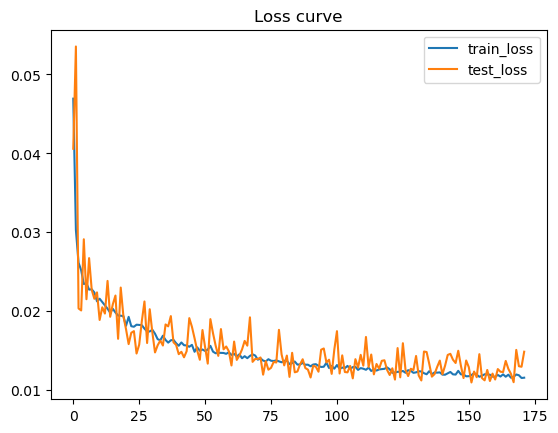

In [86]:
history = model18.fit(x_train, y_train, epochs=500, validation_data = (x_test, y_test), callbacks=callbacks_list)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.title("Loss curve")
plt.legend()
plt.show()

497/497 [==============================] - 2s 2ms/step
Train MAE: 0.01538176741451025
Train MAPE: 0.03498914837837219
Train RMSE: 0.020789605231038743


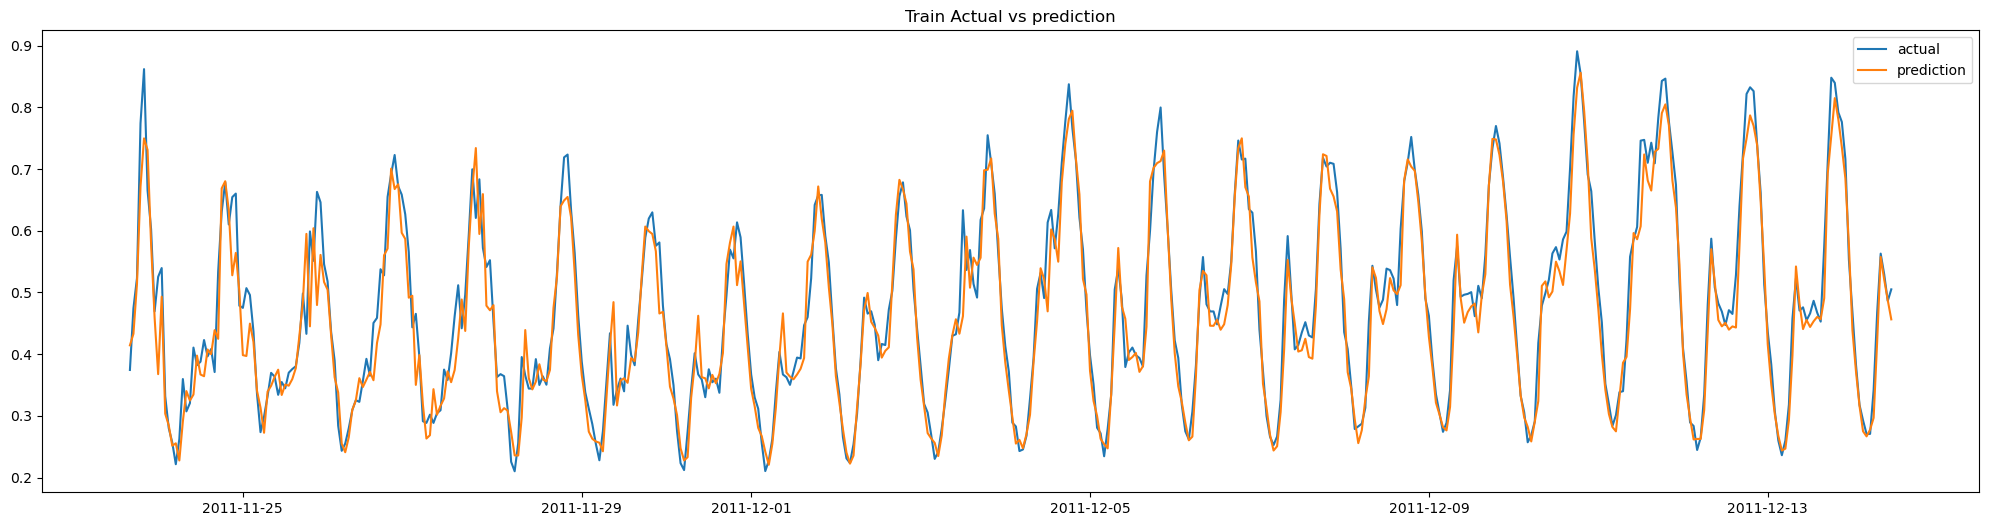

125/125 [==============================] - 0s 2ms/step
Test MAE: 0.014883842319250107
Test MAPE: 0.033110372722148895
Test RMSE: 0.019419364536202226


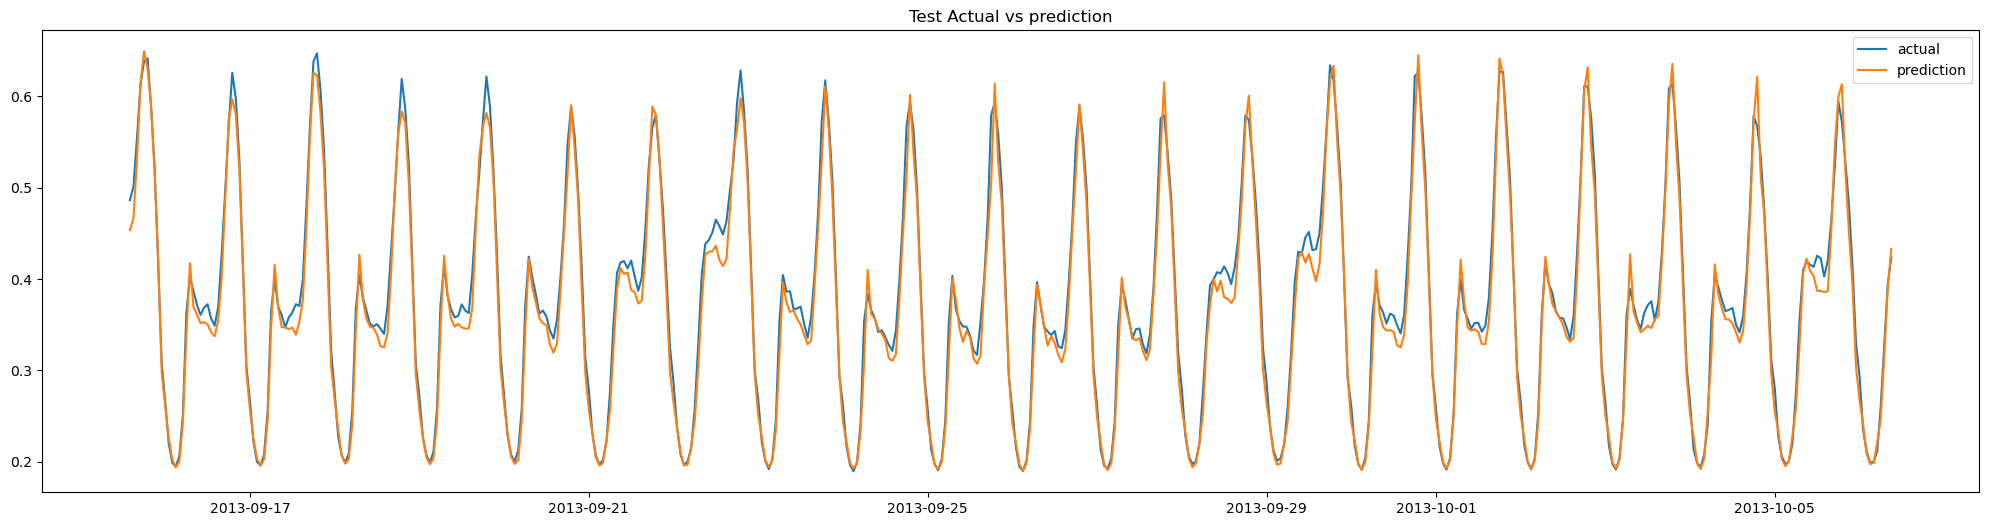

In [87]:
train_result, test_result = performance_visualization(model18, x_train, y_train, x_test, y_test, 0, 500)

In [ ]:
best_hps=tuner16.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM
layer is {best_hps.get('units')}, second LSTM layer is {best_hps.get('units_2')}, third LSTM layer is {best_hps.get('units_3')},
and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")